# Barrier Method for Quadratic Optimization

In [1]:
%matplotlib inline
import numpy as np
import cvxpy as cp
from scipy.linalg import hilbert
from scipy.sparse import diags
from matplotlib import pyplot as plt

## Writing the objective function


In [2]:
def h(x, q, P):
    return np.dot(P, x) - q

def phi(x, q, P):
    return -np.sum(np.log(-h(x, q, P)))

def quad(x, A, b):
    return np.dot(x, np.dot(A, x)) / 2 - np.dot(b, x)

def f(x, A, b, q, P, t):
    return t * quad(x, A, b) + phi(x, q, P)

## Defining the gradients


In [3]:
def phi_grad(x, q, P):
    return np.sum((P.T / (-h(x, q, P))).T, 0)

def quad_grad(x, A, b):
    return np.dot(A, x) - b

def f_grad(x, A, b, q, P, t):
    return t * quad_grad(x, A, b) + phi_grad(x, q, P)

## Defining the hessians and inverse

In [4]:
def phi_hessian(x, q, P):
    n = len(x)
    res = np.zeros((n, n))
    for i in range(n):
        res += np.matmul(P[i].T, P[i]) / (q[i]-np.dot(P[i],x))**2
    return res

def f_hessian(x, A, b, q, P, t):
    return t*A + phi_hessian(x, q, P)

def f_hessian_inv(x, A, b, q, P, t):
    return np.linalg.inv(f_hessian(x, A, b, q, P, t))

## Find starting point using **CVXPY**

In [43]:
def find_feasible(q, P):
    n = len(q)
    x = cp.Variable((n))
    s = cp.Variable((1))

    constraints = [cp.max(P @ x - q) <= s, s <= 0]
    obj = cp.Maximize(s)
    prob = cp.Problem(obj, constraints)
    prob.solve()
    return x.value

## Defining Newton and barrier methods

In [37]:
def newton(x, A, b, q, P, t, beta, alpha, max_iter, eps):
    i = 0
    
    while i < max_iter:
        i += 1
        s = 1
        fx = f(x, A, b, q, P, t)
        gradient = f_grad(x, A, b, q, P, t)
        hessian_inv = f_hessian_inv(x, A, b, q, P, t)
        v = -np.matmul(hessian_inv, gradient)
        lambd = -np.matmul(gradient, v)
        
        if lambd / 2 <= eps:
            break
        
        while np.amax(h(x + s*v, q, P)) >= 0:
            s *= beta

        while True:
            new_x = x + s*v
            new_f = f(new_x, A, b, q, P, t)
            
            if new_f <= fx - alpha * s * lambd:
                break
            s *= beta
            
        if fx == new_f:
            break
    
        x = new_x
            
    gradient = f_grad(x, A, b, q, P, t)
    hessian_inv = f_hessian_inv(x, A, b, q, P, t)
    v = -np.matmul(hessian_inv, gradient)
    lambd = -np.matmul(gradient, v)

    return x, i, lambd

In [38]:
def barrier(x, A, b, q, P, beta, alpha, max_iter, eps, mu):
    iters = []
    gap = []
    obj = []
    iter_sum = 0
    n = len(x)
    t = 1
    
    while n/t > eps:
        x, i, lambd = newton(x, A, b, q, P, t, beta, alpha, max_iter, eps)
        iter_sum += i
        iters.append(iter_sum)
        gap.append(n/t)
        obj.append(quad(x, A, b))
        t *= mu

    return x, gap, iters, obj

## Constants

In [39]:
beta = 0.5
alpha = 0.01
max_iter = 20
eps = 1e-3
mus = [1.5, 3, 5, 10]
sizes = [100, 400]

## Initialization function

In [40]:
def init(n):
    P = np.random.normal(size = (n, n))
    q = np.random.normal(size = n)
    b = np.ones(n)
    t = 1
    return P, q, b, t

## Experiments on tridiagonal matrices: tridiag(-1, 4, -1)

In [41]:
def get_tridiag(n):
    return init(n), diags([-1, 4, -1], [-1, 0, 1], shape=(n, n)).toarray()

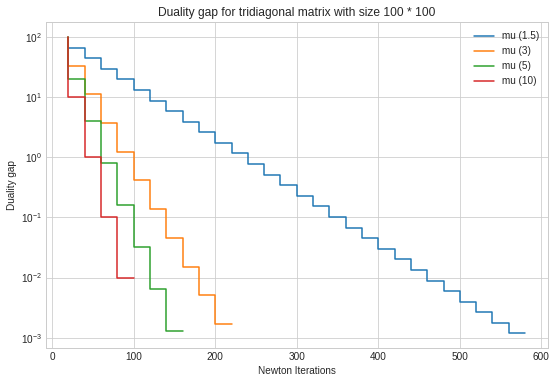

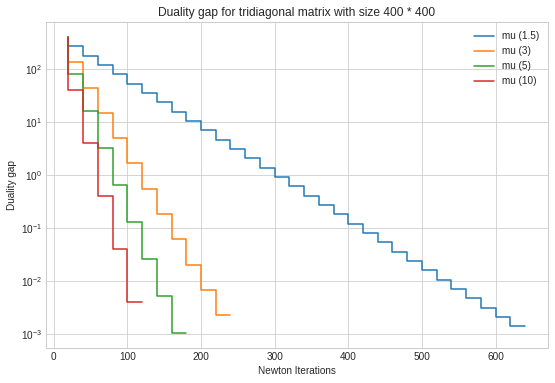

In [44]:
for n in sizes:
    (P, q, b, t), A = get_tridiag(n)
    x = find_feasible(q, P)
    
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(9, 6))
    plt.title("Duality gap for tridiagonal matrix with size {} * {}".format(n, n))
    plt.xlabel("Newton Iterations")
    plt.ylabel("Duality gap")
    
    for mu in mus:
        x, gap, iters, obj = barrier(x, A, b, q, P, beta, alpha, max_iter, eps, mu)
        plt.step(iters, gap, label='mu ({})'.format(mu))
        
    plt.yscale('log')
    plt.legend()
    plt.show()

## Experiments on Hilbert matrices

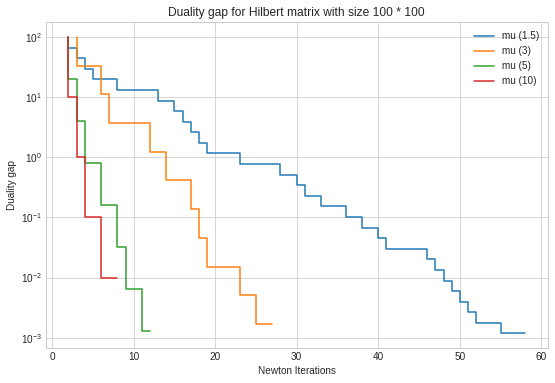

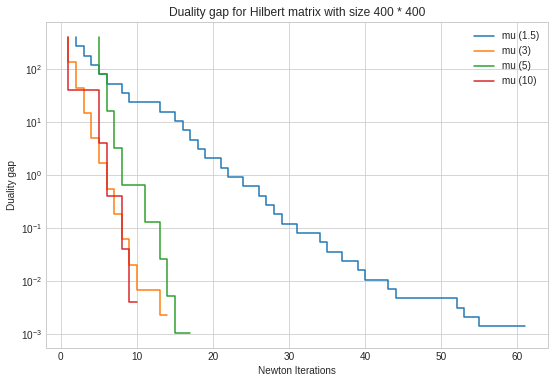

In [46]:
for n in sizes:
    A = hilbert(n)
    P, q, b, t = init(n)
    x = find_feasible(q, P)
    
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(9, 6))
    plt.title("Duality gap for Hilbert matrix with size {} * {}".format(n, n))
    plt.xlabel("Newton Iterations")
    plt.ylabel("Duality gap")
    
    for mu in mus:
        x, gap, iters, obj = barrier(x, A, b, q, P, beta, alpha, max_iter, eps, mu)
        plt.step(iters, gap, label='mu ({})'.format(mu))
        
    plt.yscale('log')
    plt.legend()
    plt.show()